# QML model creation and comparison with classic ML models

## Introduction

<small>The objective of this project here is to create a **QML model** that, starting from an artificial, customized dataset, is able to classify each data in one of the 2 categories, anomaly or normal data. Each data emulates a packet in the network, despite the fact that it has only a few features characterizing it, while in real world applications packets are made by a large number of them. <br>
We will consider 2 different scenarios, starting from data made by 4 features, and then trying to "scale up" the application, using something like 8-12 features, highlighting the increasing slowness of Quantum Model just by adding a few qubits. <br>
For each scenario a comparison with a classic ML model will be made, showing the current advantages and disadvantages, also discussing some potential future benefits.</small>

## 4-features scenario

<small>In this first scenario, we consider a dataset characterised by packets-like data, characterised by 4 features, that are used to classify them between anomalies and normal packets. These features have been selected from a pool of characteristics and fields that a real packet has, in order to make the classification task non-linear to solve, trying to make the problem suitable for a quantum model, also explaining what possible advantages it can have. 
These 4 features are: 
1. Connection Duration (*Duration*): normal range: 0.5-60 seconds 
2. Bytes transferred (*BytesTransferred*): normal range: 1000-1000000 bytes 
3. Destination frequency (*DestPortFrequency*): normal range: 1-5 port contacts per minute 
4. Number of unusual flags/states (*UnusualFlags*): normal value: 0 unusual flags

We have created 2 types of anomalies, just to make the classification problem harder, that modify one or more of these features, exiting from the normal ranges. The 2 types are: 
1. **Scanning attack**: low duration, few bytes transferred, high port frequency, no unusual flags 
2. **Data exfiltration**: very high duration, lots of bytes transferred, very low port frequency, unusual flag presence

The entire artificial dataset is generated by the function *generate_dataset4()*, with every sample having its correspondant label (0 for normal data, 1 for anomaly). This function, along with *data_plot()*, can be found in *dataset.py* file.</small>

In [1]:
# Import the functions needed for the data generation
from dataset import generate_dataset4, plot_data

<small>The first step we need to do is to generate our sample dataset, and then we need to split it in 2 subset, one for training our model and the other one for testing purposes. We use pandas *DataFrame* object to have a table view of them. We opt for a dataset with 1000 samples, just to better train the model. It was demonstrated that a quantum model can easily work with a dataset up to a few thousands of samples.</small>

In [2]:
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import numpy as np
import time

feature_dim = 4
# Generate the dataset
np.random.seed(42) # For reproducibility, we obtain the same dataset every time
dataset = generate_dataset4(1000)
# Split the dataset in train and test set
train_set, test_set = train_test_split(dataset, test_size = 0.2, random_state=42)
# Convert the dataset to DataFrame
train_set = DataFrame(train_set, columns = ['Duration', 'BytesTransferred', 'DestPortFrequency','UnusualFlag', 'Label'])
test_set = DataFrame(test_set, columns = ['Duration', 'BytesTransferred', 'DestPortFrequency','UnusualFlag', 'Label'])

test_set

,Duration,BytesTransferred,DestPortFrequency,UnusualFlag,Label
0,0.002347,0.000611,0.582906,0.048432,1.0
1,0.007290,0.001880,0.017189,0.056402,0.0
2,0.001884,0.002494,0.035169,0.055184,0.0
3,0.006422,0.001280,0.056516,0.054616,0.0
4,0.007637,0.003179,0.032070,0.033227,0.0
...,...,...,...,...,...
195,0.009156,0.001512,0.024981,0.053045,0.0
196,0.007873,0.002950,0.040713,0.064549,0.0
197,0.002295,0.000610,0.691501,0.049317,1.0
198,0.008309,0.002408,0.047826,0.057280,0.0


### Map the problem to a Quantum Circuit

<small>The next step is to map our classification problem to a Quantum Circuit. Since we have classical data as input data, we first need to code them in Qubits, just to be able to use a Quantum model. <br>
We know that in classical ML algorithm there is the concept of ***Feature mapping***, that consist in using a function, $\Phi(\vec{x})$, where $\vec{x}$ is an initial input sample, that map this vector to an higher dimension. This is crucial because most of the time it is not easy to find a line in 2D, a plane in 3D or an Hyperplane in general that makes a clear separation between 2 classes. For this reason we must sometimes put the problem in some higher dimensions, where there will be a more explicit division. <br>
In QML, Data Encoding consist on transforming a classical data $\vec{x}$, in a Quantum state, $\ket{\vec{x}}$: 
$$
x -> \ket{\vec{x}} = U(\vec{x})\ket{0}
$$
This transformation basically maps data into the Hilbert Space, where Quantum state live. In general, N qubits live in a space of $2^N$ dimension, which is a way bigger than the original space. For instance, if we consider a data vector of 4 features, we will map it into a space of dimension 16.<br>
For this first case we will consider a ZZ-feature map. Thanks to 2-qubit gates that introduce entanglement in the circuit, we can also code some relationship between different features, and this let us to manage in an easier way our classification problem, which was meant to be non-linear. </small>

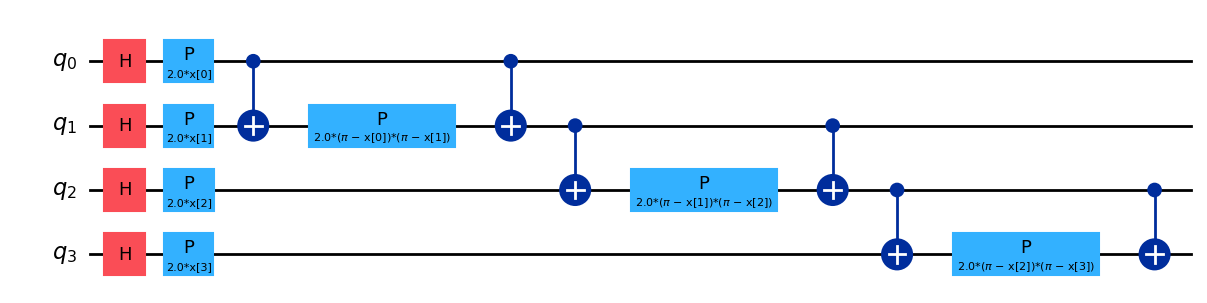

In [3]:
from qiskit.circuit.library import ZZFeatureMap

# Map the problem to a Quantum Circuit
zz_feature_map = ZZFeatureMap(
    feature_dimension = feature_dim, entanglement = 'linear', reps = 1 # num of qubits = num of features
)
zz_feature_map.decompose().draw("mpl",scale = 1)

<small>As next, we choose our Ansatz. The *Ansatz* is a variational circuit, known as $W(\theta)$, that is defined by a set of parameters $\theta$. Those will be varied by classical optimization algorithms to find the set of parameters that yields the best classification of images by the quantum circuit.<br>
There are many considerations when selecting an ansatz: in what hardware we will run this model; what information given by the classification problem can be used to select our ansatz; what number of parameters must be used in order to not encounter the so called *Barren plateaus* phenomenon. For this trivial case, we start choosing *real-amplitudes* local circuit.</small>

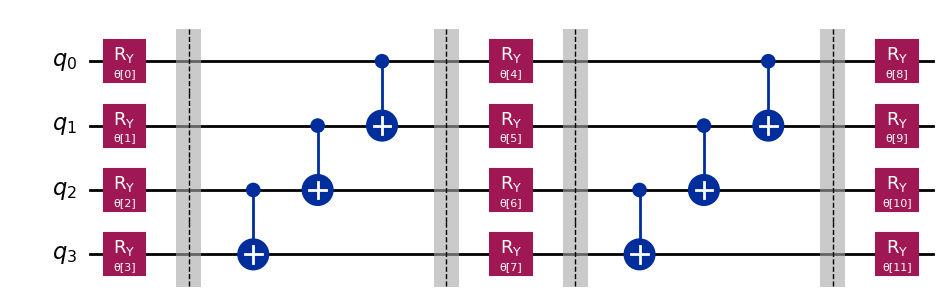

In [4]:
from qiskit.circuit.library import real_amplitudes

ansatz = real_amplitudes(
    feature_dim, reps = 2, insert_barriers = True
) # this is our Ansatz, we repeat it 2 times to have better results

ansatz.draw("mpl",scale = 1)

<small>Now that we have chosen our Feature Map and Ansatz circuits, we can group them toghether to form our actual Quantum model, that will be trained and then tested to classify our input data. In this scenario we opt for a VQC (*Variational Quantum Classifier*), that is a variational algorithm where the measured bitstrings are interpreted as the output of a classifier. <br>
To use the VQC, we must use the **qiskit_machine_learning** library, which has an implementation of it. We will run this circuit on a trivial simulator, which does not have any noise that could be present in a real quantum hardware, to see what happens in ideal conditions. We will try to use a noisy, hardware-like simulator in the next scenario.</small>

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


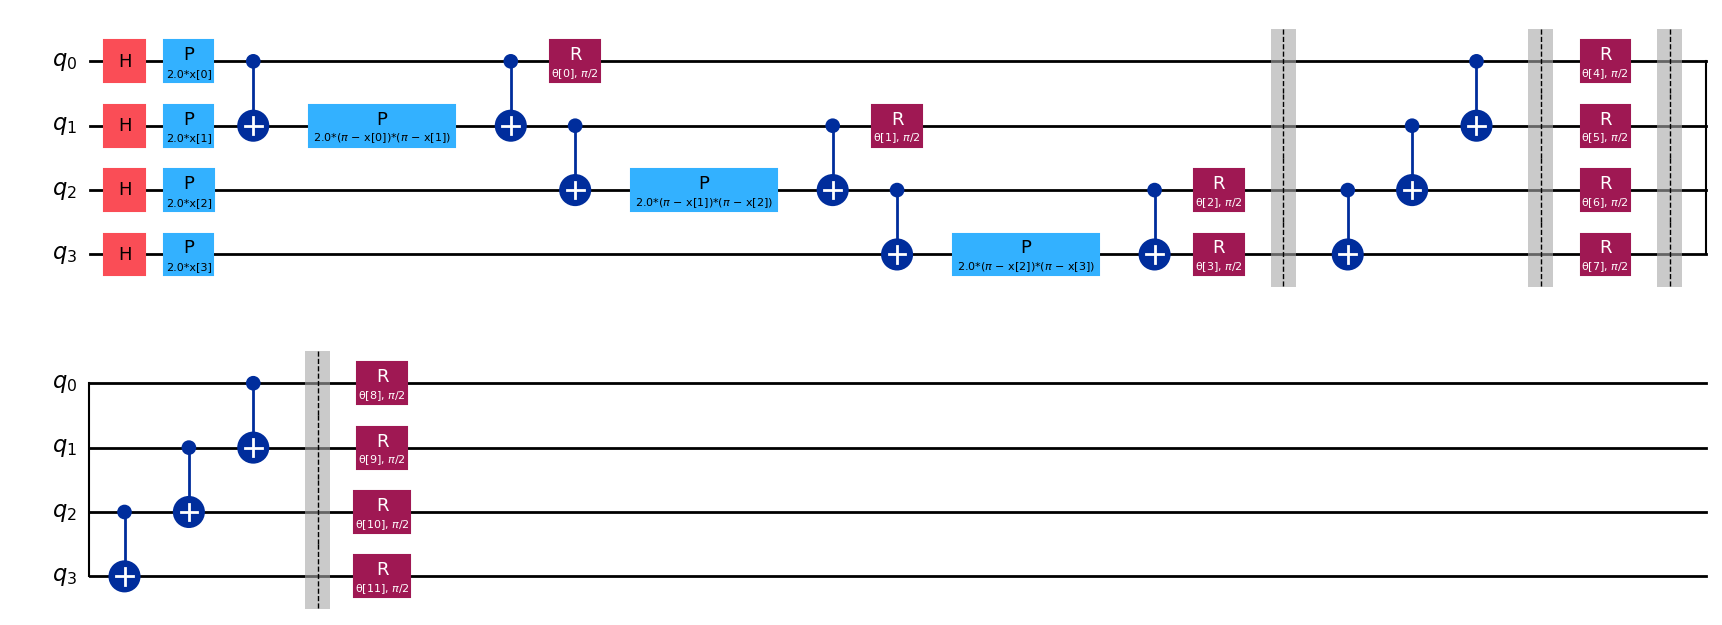

In [5]:
# construct the variational quantum classifier
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.optimizers import COBYLA # this is a classical local optimizer
from qiskit.primitives import StatevectorSampler as Sampler
from IPython.display import clear_output
import matplotlib.pyplot as plt
'''We don't use global optimizers because they are very slow and we don't need them for this trivial case.'''
sampler = Sampler() # we use a simple sampler, which is without noise

# Define a callback function to monitor the training process
def callback_function(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function values against iterations")
    plt.xlabel("Iterations")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

vqc = VQC(
    feature_map = zz_feature_map,
    ansatz = ansatz,
    loss = 'cross_entropy',
    optimizer = COBYLA(maxiter = 100), # we do not need a gradient function for COBYLA optimizer
    callback = callback_function,
    sampler = sampler,
)

vqc.circuit.decompose().draw("mpl",scale = 1)

<small>From the previous code snippet, we can see that a callback fuction has been defined. The role of this function is to trace all the values computed in each execution of the cost function by the Ansatz circuit, in order to better trace how well the whole algorithm has worked.<br>
Following the creation of the VQC circuit, we proceed in training and test it, using respectively the function *fit()* and *score()*, with the latter that output the mean accuracy of the model. Since we have inserted the callback function in the definition of the VQC, the callback function is repeatedly called during the *fit()* function, and as we can see it plots for each iteration of the optimization algorithm, the computed value of the cost function.<br>
We can notice that this model has achieved a final score of *98%*, which is an excellent score, despite the fact that the model took a total of almost 6 minutes to complete all the operations, even with a relatively small dataset, because as we will see a classical algorithm can do these operations in few instants.</small>


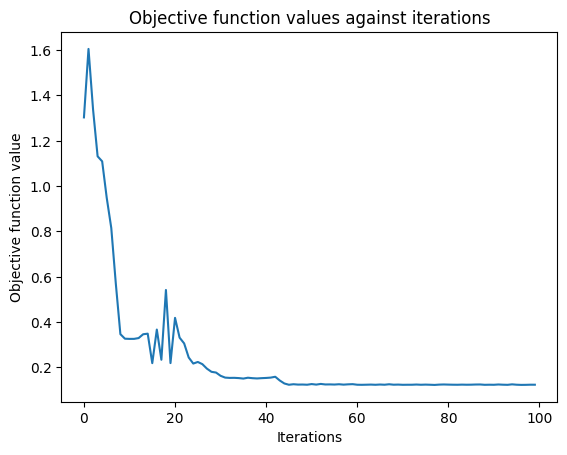

Training completed in 577.75 seconds.


0.98

In [8]:
# Train the model
X_train = train_set.drop('Label', axis = 1).to_numpy()
Y_train = train_set['Label'].to_numpy()
X_test = test_set.drop('Label', axis = 1).to_numpy()
Y_test = test_set['Label'].to_numpy()
#print(type(X_train))

objective_func_vals = [] # Array to store the evaluations of the objective function
start_time = time.time() # Start the timer
print("Training the model...")
vqc.fit(X_train, Y_train)
end_time = time.time() # End the timer
print(f"Training completed in {end_time - start_time:.2f} seconds.")
#Test the model
vqc.score(X_test, Y_test) 

### Performance comparison with a classical ML algorithm

<small>In order to make a comparison between an existent classical Machine Learning algorithm and a Quantum one, in this first scenario we choose the so called *Random Forest* algorithm, which is implemented in the scikit-learn module. The basic concept of this algorithm is to combine the output of multiple decision trees to reach a single result. <br>

**What is a decision tree?**<br>
Decision tree is a tree structure, in which we start from a basic question, and from that we can ask a series of questions to determine an answer. These questions make up the decision nodes in the tree, acting as a means to split the data. Each question help an individual to arrive at a final decision, which would be denoted by a leaf node. When multiple decision trees form an ensemble in the random forest algorithm, they predict more accurate results.
![Random forest algorithm](Random_forest_image.png)
</small>

In [9]:
# import the library 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train a classical model for comparison
rf = RandomForestClassifier(
    min_samples_split= 10,
    min_samples_leaf= 5,
    random_state = 42
)

<small>As we can see from the code below, this classical model achieves perfect results, since we have all metrics set to 100%, and moreover this model has been trained in much less time than the quantum one, since the latter has completed its training process in almost 10 minutes, while the first one was impressively fast. In conclusion, even in a trivial scenario like the one discussed here, we can already see all the disadvantages of a quantum model in terms of precision and time of training and testing. This is the main reason why we still use nowadays classical algorithm to perform ML tasks. </small>

Classical model training completed in 0.09 seconds.
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       159
         1.0       1.00      1.00      1.00        41

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



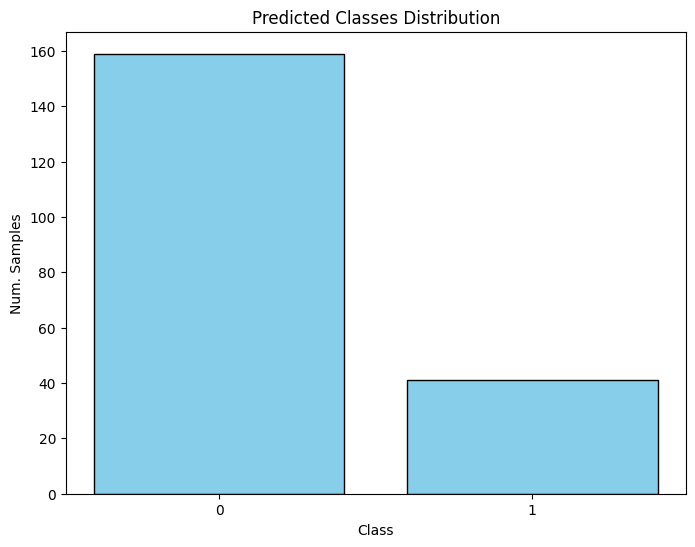

In [10]:
# Train and test the model
start_time2 = time.time()
rf.fit(X_train, Y_train)
end_time2 = time.time() # we measure the time of training
print(f"Classical model training completed in {end_time2 - start_time2:.2f} seconds.")

rf.score(X_test, Y_test)

# Make predictions and evaluate the model
y_pred = rf.predict(X_test)
print(classification_report(Y_test, y_pred))
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Num. Samples")
plt.title("Predicted Classes Distribution")
plt.show()

## N-features scenario

<small> In this second scenario, we try to scale up our previous scenario. In particular, we try now to consider a dataset made by 10 features, which is still far away to any realistic scenario of a network traffic, but as we will see it still is a feasible number for any quantum model, especially if we run it on a real quantum hardware. Starting from the initial 4 features, we have added 6 new features which are very useful to make some new categories of anomalies, in order to make the classification problem even more difficult to be done.<br> 
These new 6 features are: 
1. Packet size mean (*PacketSizeMean*): mean size of a packet in a session. Scanning attack may have very small packets, while in data exfiltration attack packets may have large dimensions.
2. Packet size standard deviation (*PacketSizeStdDev*): variability in the packets size. Normal session tend to have a certain variability, while some attacks may have a small one.
3. Protocol (*Protocol*): network protocol type (eg. TCP,UDP,ICMP). Scanning attack are usually based on specific protocols like ICMP or UDP. This field is coded numerically (0 for TCP, 1 for UDP ...)
4. Inter packet arrival time mean (*InterPacketArrivalTimeMean*): mean time of consecutive packets reception. A scanning attack may have a very small interval between packets, while an exfiltration attack is usually characterised by a larger interval.
5. Session start time (*SessionStartTimeOfDay*): time of the day in which the session has begun. Anomalies can happen during strange hours.
6. Number of connections to an IP address (*NumberOfConnectionsToIP*): total number of host connections to a specific IP address.

Based on these 10 features, we may define a total of 3 class of anomalies, one more than the previous scenario:
1. **Scanning attack**: low duration, low bytes transferred, high Destination Port frequency, low mean packet size, high inter packet arrival mean time.  
2. **Data exfiltration attack**: high duration, high bytes transferred, low Destination Port frequency, high mean packet size, low inter packet arrival mean time. 
3. **DDoS Attack**: low duration, low bytes transferred, high Destination Port Frequency, very high number of connections to a specific IP address, variable mean packet size. <br>

This artificial dataset has been generated using *gen_dataset_high()* function, which is present in the *dataset.py* file. 

In [17]:
from dataset import gen_dataset_high

In [19]:
feature_dim_high = 10
# Generate the dataset
np.random.seed(42) # For reproducibility, we obtain the same dataset every time
dataset = gen_dataset_high(100)
# Split the dataset in train and test set
train_set, test_set = train_test_split(dataset, test_size = 0.2, random_state=42)
# Convert the dataset to DataFrame
train_set = DataFrame(train_set, columns = ['Duration', 'BytesTransferred', 'DestPortFrequency','UnusualFlag', 'PacketSizeMean', 
            'PacketSizeStdDev', 'Protocol','InterPacketArrivalTimeMean','SessionStartTimeOfDay','NumberOfConnectionsToIP', 'Label'])
test_set = DataFrame(test_set, columns = ['Duration', 'BytesTransferred', 'DestPortFrequency','UnusualFlag', 'PacketSizeMean',
            'PacketSizeStdDev', 'Protocol','InterPacketArrivalTimeMean','SessionStartTimeOfDay','NumberOfConnectionsToIP', 'Label'])

test_set

,Duration,BytesTransferred,DestPortFrequency,UnusualFlag,PacketSizeMean,PacketSizeStdDev,Protocol,InterPacketArrivalTimeMean,SessionStartTimeOfDay,NumberOfConnectionsToIP,Label
0,0.144808,0.636866,0.022633,0.735117,0.695359,0.285801,0.037885,0.224605,0.461747,0.000891,1.0
1,0.006460,0.003285,0.023980,0.051170,0.379176,0.391679,0.404953,0.025226,0.471128,0.001666,0.0
2,0.000989,0.001849,0.028356,0.049323,0.327419,0.854480,0.368227,0.037393,0.604638,0.001090,0.0
3,0.004606,0.001674,0.057378,0.044794,0.569476,0.408775,0.425116,0.034912,0.531501,0.002257,0.0
4,0.003735,0.001966,0.699292,0.055835,0.495291,0.372019,1.000000,0.004295,0.585242,0.527232,1.0
5,0.005162,0.001471,0.050416,0.086459,0.539487,0.558742,0.430551,0.025543,0.607574,0.001630,0.0
6,0.304146,0.693516,0.025020,0.937298,0.765413,0.249225,0.037885,0.554589,0.372359,0.001094,1.0
7,0.004697,0.001264,0.776237,0.032794,0.461507,0.207793,1.000000,0.003122,0.452897,0.663198,1.0
8,0.008755,0.001823,0.033075,0.043958,0.482836,0.452147,0.637122,0.061631,0.370074,0.002034,0.0
9,0.001288,0.001467,0.037721,0.022958,0.473408,0.594146,0.881888,0.048543,0.507608,0.002756,0.0


### Map the problem to a quantum circuit

<small>Following the same process of the first scenario, the first thing to do here is to map our dataset in the quantum world, in order to be able to train our quantum model over these samples. The backend used in this case is completely different to the one used in the previous case. Instead of using a trivial backend simulator like we did before, here we're using a more realistic simulator, for instance a **FakeMelbourneV2** backend, which emulates most of the noise present in a real quantum hardware. This type of backend simulator can be found in the *qiskit_ibm_runtime.fake_provider* module, which has a list of available fake backends. <br>
The reason why we use a fake backend instead of using directly a real quantum hardware is because for our purposes we need spending a lot of time for executing a task, and this will force to pay an extra fee to IBM to use the hardware. Instead, using a fake backend is an optimal trade-off between having some real hardware characteristics like noise and reducing to the minimum any eventual cost.<br>
</small>

In [20]:
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2 # we will use a fake noisy device for testing
from qiskit_machine_learning.state_fidelities import ComputeUncompute

device_backend = FakeMelbourneV2() # 15 qubit device for testing 
print(device_backend.n_qubits)
print(device_backend.configuration().coupling_map)
print("-----------------------")
properties = device_backend.properties()

readout_error_q0 = properties.readout_error(0)
print(f"Readout error qubit 0: {readout_error_q0:.4f}")

# Stampa il tasso di errore di un gate a un qubit (es. gate 'sx' su qubit 1)
gate_error_q1 = properties.gate_error('sx', 1)
print(f"Gate 'sx' mean error on qubit 1: {gate_error_q1:.4f}")

# Stampa il tasso di errore di un gate a due qubit (es. gate 'cx' su qubit 0 e 1)
gate_error_q0_q1 = properties.gate_error('cx', [0, 1])
print(f"Gate 'cx' mean error on qubit 0 e 1: {gate_error_q0_q1:.4f}")

# Stampa il tempo T1 di un qubit
t1_q0 = properties.t1(0)
print(f"Qubit 0 time T1: {t1_q0:.2f} µs")

15
[[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 12], [3, 2], [3, 4], [3, 11], [4, 3], [4, 5], [4, 10], [5, 4], [5, 6], [5, 9], [6, 5], [6, 8], [7, 8], [8, 6], [8, 7], [8, 9], [9, 5], [9, 8], [9, 10], [10, 4], [10, 9], [10, 11], [11, 3], [11, 10], [11, 12], [12, 2], [12, 11], [12, 13], [13, 1], [13, 12], [13, 14], [14, 0], [14, 13]]
-----------------------
Readout error qubit 0: 0.0265
Gate 'sx' mean error on qubit 1: 0.0010
Gate 'cx' mean error on qubit 0 e 1: 0.0184
Qubit 0 time T1: 0.00 µs


<small>The fake backend we have here comes with some interesting methods and attributes. One of the most important is *.properties()*, which gives us a list of all the infos about errors implemented in the backend, the number of "physical" qubits mapped and so on. In this code snippet for instance we can see some error parameters like: 
1. **Readout error**: is the probability that a qubit is measured as a wrong value. For instance, the probability that a qubit with state $\ket{0}$ is seen as 1.
2. **One qubit gate error**: is an imperfection in the execution of a single-qubit operation in quantum computer, where the error rate is the probability of an incorrect outcome. Errors can occur due to factors like *decoherence* and *leakage*. 
3. **Two qubit gate error**: this type of error represents the major obstacle in building scalable quantum computing, with rates significantly higher than single-qubits errors. These errors arises from the complex physical mechanisms of entanglement and are exacerbated by decomposing arbitrary two-qubit rotations into sequences of basic "stock" gates.
4. **Time T1 of a qubit**: also known as *Relaxation time*, it measures how much time a qubit can remain in $\ket{1}$ before decaying into the fundamental state $\ket{0}$. This phenomenon happens thanks to the interaction of the qubit with the environment, causing energy loss and/or thermal noise. <br>

Another information that can be seen is the coupling map of all the 15 qubits, which can be a valuable information especially when we transpile the problem into the actual backend, because we have to adapt our abstract circuit to the physical qubits that are available.<br>
As in the first scenario, we opt for a ZZ feature map, which is still a valuable solution to map a dataset with 10 functionalities, as it is very useful to map different features toghether, thanks to the entanglement introduced by CNOT gates.
 
</small>

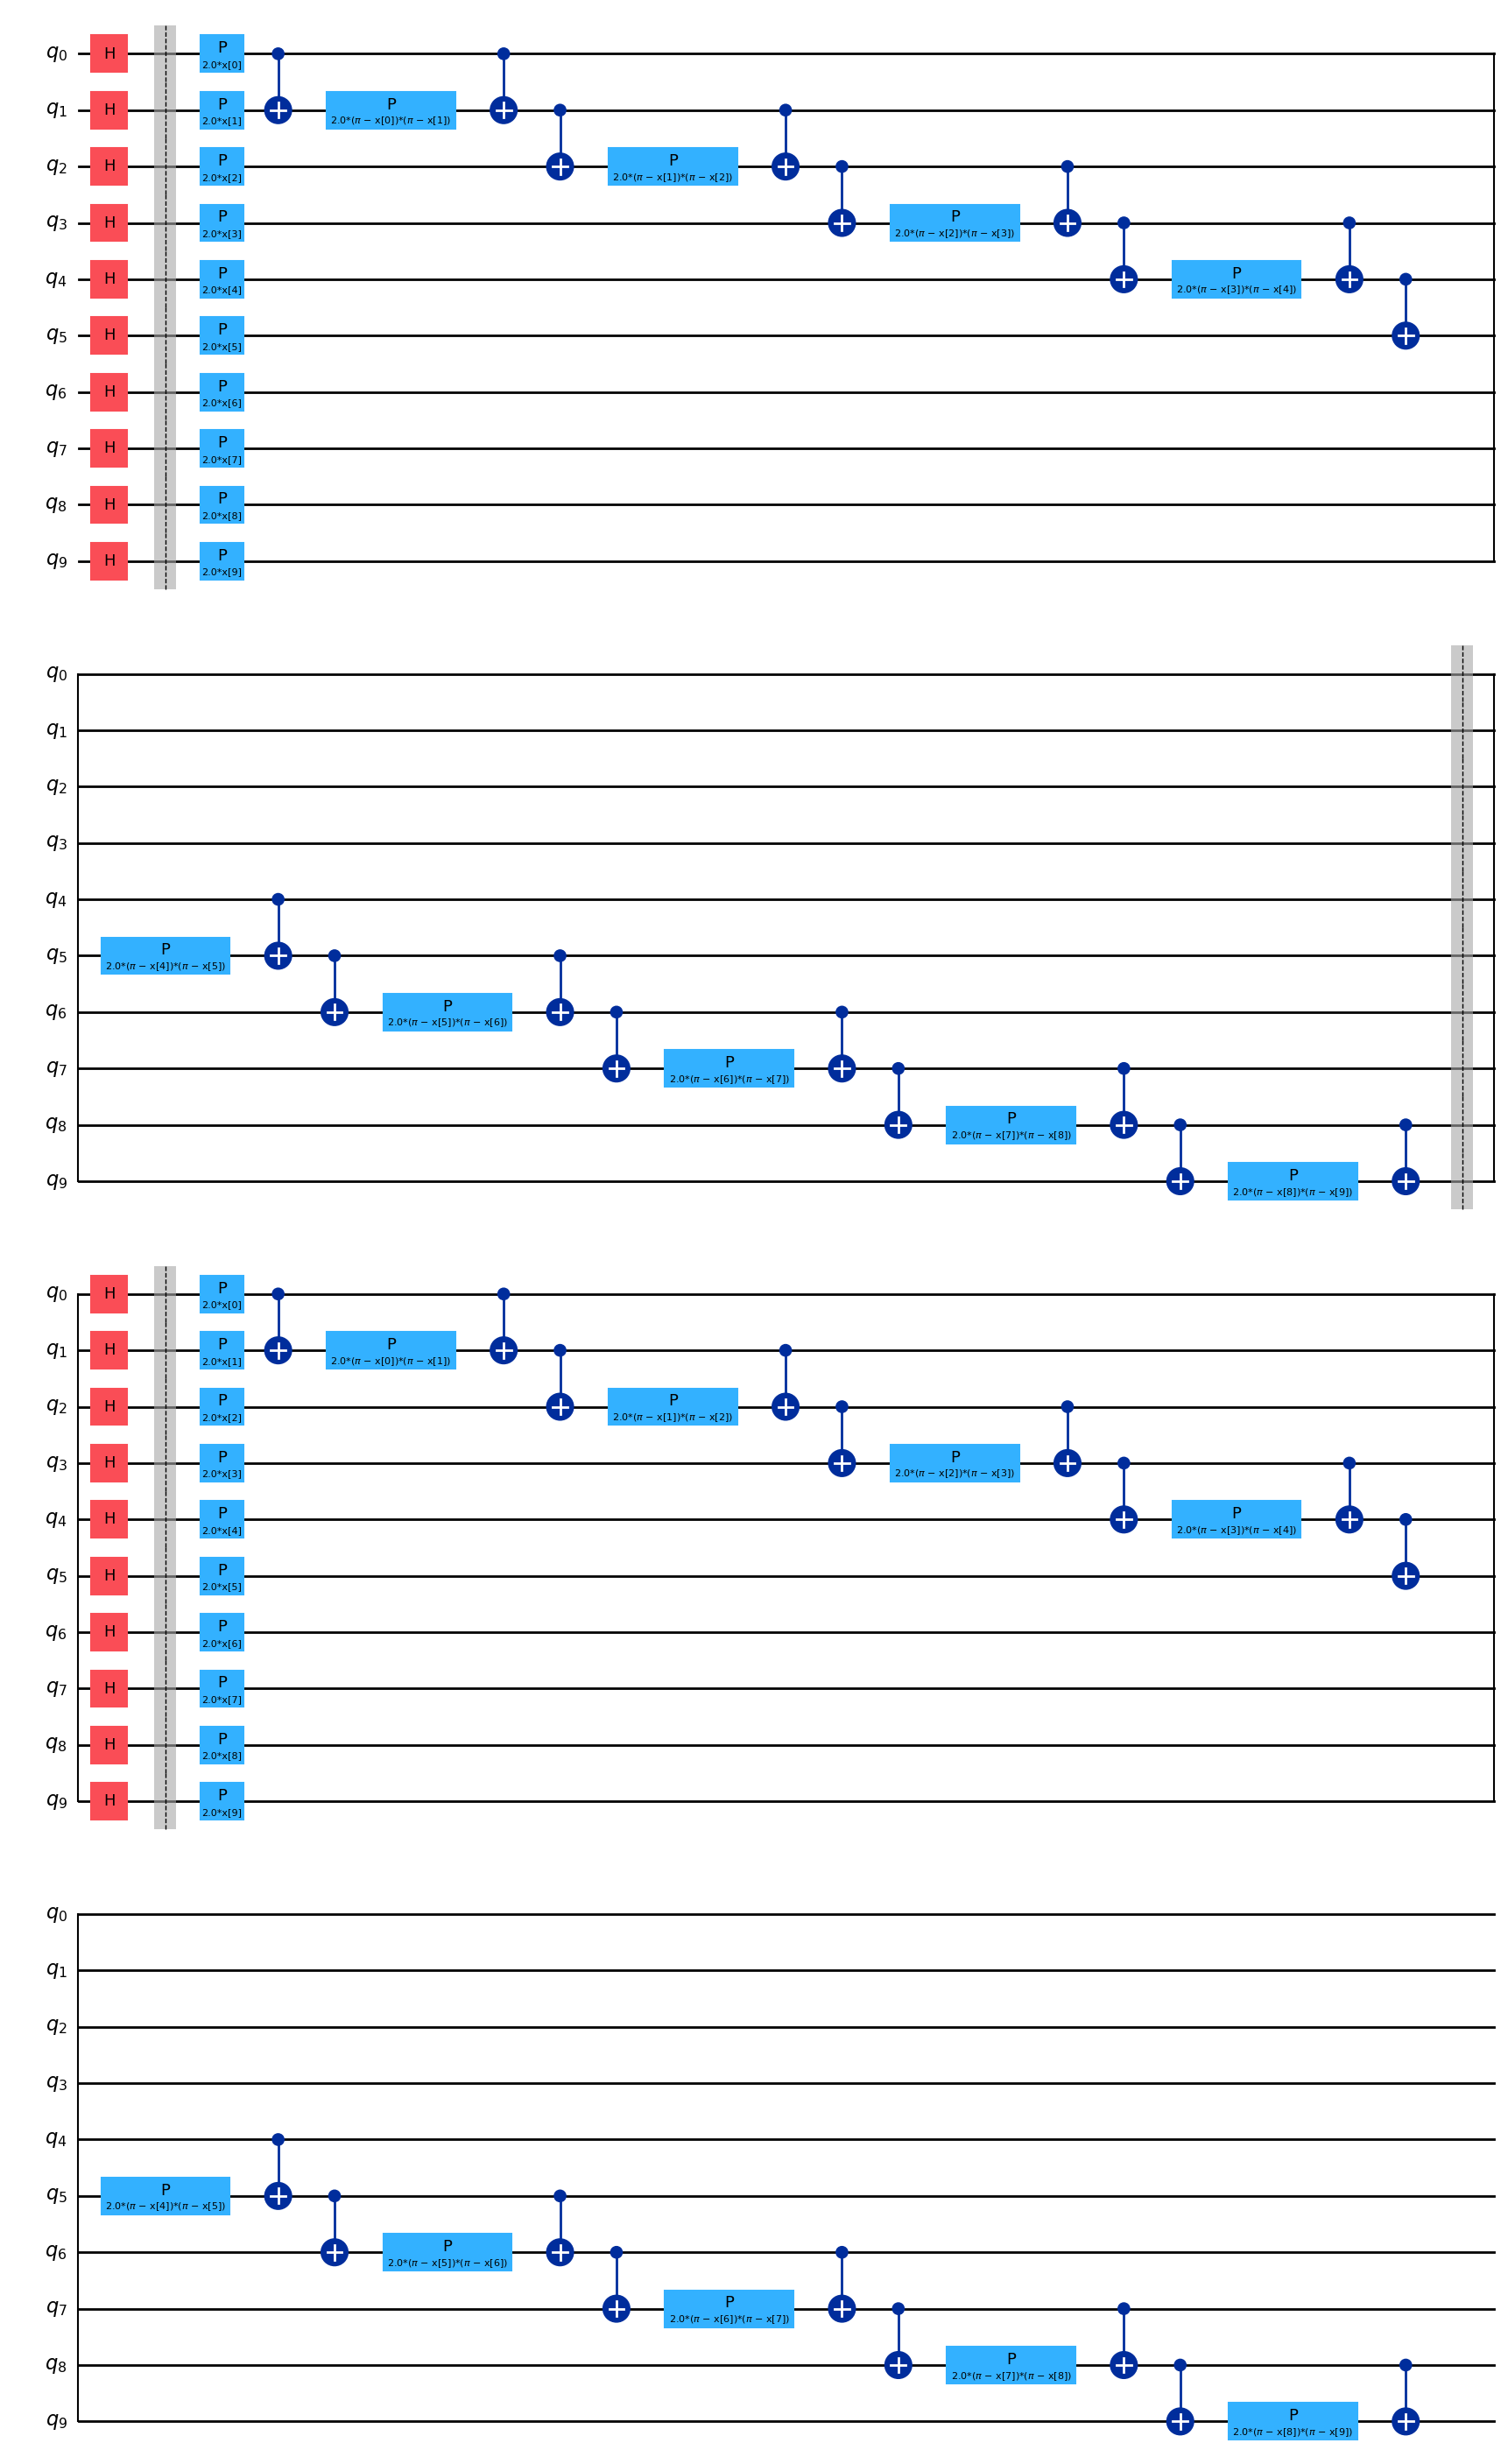

In [21]:
from qiskit.primitives import BackendSampler as Sampler

zz_feature_map_high = ZZFeatureMap(
    feature_dimension = feature_dim_high, entanglement= 'linear', reps = 2, insert_barriers= True
)

zz_feature_map_high.decompose().draw("mpl",scale = 1)

<small>Here comes the biggest novelty in this scenario, as we try now to create a quantum model which is not using anymore VQC algorithm, but instead is using QSVC, which is a classification algorithm that exploits the computation of a quantum kernel, which is used as an input to a classical learning algorithm, SVM (*Support Vector Machine*) for instance. <br>

**Why QSVC?** <br>

Kernel methods are a collection of pattern analysis that use kernel functions to operate in a high-dimensional feature space. The best known application is in Support Vector Machines (SVMs), supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries. The kernel function in fact implicitly maps input data into his higher dimensional space, where it can be easier to solve the initial problem. This is an effect known as "kernel trick". <br>
The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically: 
$$ K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$$

where: 
* $K_{ij}$ is the kernel matrix
* $\vec{x_i}$, $\vec{x_j}$ are *n* dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a | b \rangle \right|^{2}$ denotes the overlap of two quantum states *a* and *b*

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms.
In this scenario, for instance, the quantum kernel will be at first used in the QSVC class provided by *qiskit-machine-learning* module.
The advantage of using this kind of algorithm instead of using again VQC is that Quantum kernel algorithms construct their kernel using a quantum feature map, and since they already map classical data into the Hilbert space $C^{n}$ for n possible states, which is an higher dimension space, this is analogous to the classical kernel trick. To construct the kernel matrix, which is a Gram matrix $K \in \mathbb{R}^{M \times M}$, the number of evaluation of the kernel is a function $O(M^2)$, so it depends only on the number of samples M. Instead, the number of features N have an impact just on the single evaluation (more features = deeper circuits). This is the reason why we can use this kind of algorithm if we want to consider a scenario with more features. <br>
On the other hand, the major limitation is represented as we saw by the limited number of samples that we must consider in order to not overwhelm the quantum hardware/simulator during the training/test process.
![Quantum kernel circuit](quantum_kernel_circuit.avif)
</small>

In [ ]:
sampler = Sampler(backend = device_backend)

fidelity = ComputeUncompute(sampler = sampler)

quant_kernel = FidelityQuantumKernel(
    fidelity = fidelity,
    feature_map = zz_feature_map_high,
    evaluate_duplicates = "all"
)

C:\Users\anton\AppData\Local\Temp\ipykernel_46240\1008563776.py:1: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = Sampler(backend = device_backend)
C:\Users\anton\AppData\Local\Temp\ipykernel_46240\1008563776.py:3: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity = ComputeUncompute(sampler = sampler)


<small> The QSVC class extends the scikit-learn SVC classifier. It uses a quantum kernel to compute the quantum kernel matrix, that is then put in input to a classical training algorithm, which is in this case SVM. As we have anticipated before, the main limitation in the code below is that we have generated a dataset with only 100 samples, which is near the maximum value that a quantum model can manage without being too slow in computation. <br>
Moreover, even with 100 samples, whose 80% is for the training phase, the quantum model results very slow, in fact it has completed the training process in almost half an hour, much more time than in the first scenario. Also the accuracy of the model is not so high, near 70%. These results highlight what are the main limitations of Quantum Machine Learning, as we need to have a specific problem with specific condition to obtain a *Quantum Advantage*. <br>
We have tried here to scale up our application, trying to be more close to what is a real network, but we are still far away to be able to work with real network packets, which are actually represented by hundreds of features. Also the testing phase is quite a problem, since we have to compute another kernel matrix, but we are still considering here few samples, 20 for instance, that can cause some distortion in what is the real data distribution in classes, or we may not detect a possible overfitting in the model.
</small>

In [32]:
qsvc = QSVC(quantum_kernel = quant_kernel)

X_train_high = train_set.drop('Label', axis = 1).to_numpy()
Y_train_high = train_set['Label'].to_numpy()
X_test_high = test_set.drop('Label', axis = 1).to_numpy()
Y_test_high = test_set['Label'].to_numpy()

#qsvc.get_params(deep = True)
qsvc.set_params(random_state = 42) # for reproducibility

# train the model
try:
    print("Traning the quantum model with 100 samples...")
    start_time3 = time.time()
    qsvc.fit(X_train_high, Y_train_high)
    end_time3 = time.time() # we measure the time of training
    print(f"Quantum model training completed in {end_time3 - start_time3:.2f} seconds.")
    
    # test the model
    start_time4 = time.time()
    score = qsvc.score(X_test_high, Y_test_high)
    end_time4 = time.time() # we measure the time of testing
    print(f"Quantum model testing completed in {end_time4 - start_time4:.2f} seconds.")
    print(f"Quantum model accuracy: {score:.2f}")
except Exception as e:
    print("ERROR: The training dataset is too large for the quantum model. Please reduce the number of samples.")
    print(f"Exception: {e}")

Traning the quantum model with 100 samples...
Quantum model training completed in 1066.71 seconds.
Quantum model testing completed in 401.95 seconds.
Quantum model accuracy: 0.70


              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82        14
         1.0       0.00      0.00      0.00         6

    accuracy                           0.70        20
   macro avg       0.35      0.50      0.41        20
weighted avg       0.49      0.70      0.58        20



c:\Users\anton\quantum\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\anton\quantum\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\anton\quantum\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


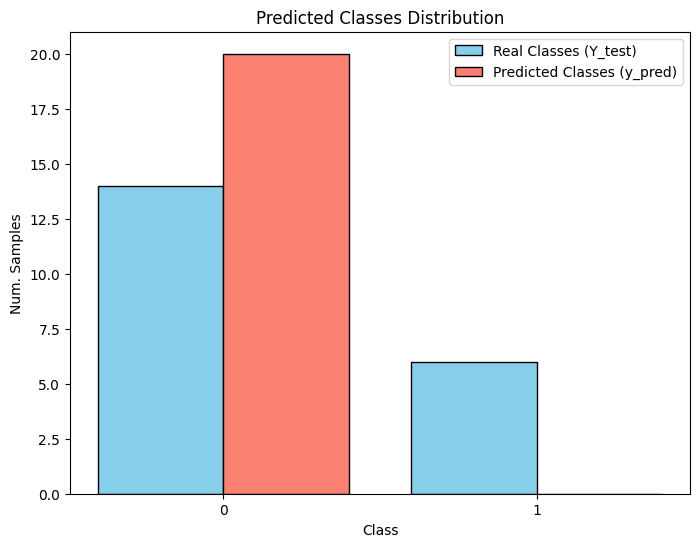

In [ ]:
y_pred_high = qsvc.predict(X_test_high)
print(classification_report(Y_test_high, y_pred_high))

# make a comparison between the predicted and real classes
plt.figure(figsize = (8,6))
plt.hist(
    [Y_test_high, y_pred_high],
      bins=[-0.5, 0.5, 1.5], 
      rwidth=0.8, 
      color=['skyblue', 'salmon'],
      label = ['Real Classes (Y_test)', 'Predicted Classes (y_pred)'], 
      edgecolor='black')
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Num. Samples")
plt.title("Predicted Classes Distribution")
plt.legend()
plt.show()

### Performance comparison with a classical ML algorithm

<small>As we did in the first scenario, we perform a comparison with an analogous classical algorithm to see what are the differences in terms of performance. We use the classical equivalent algorithm, which is SVC to see in how much time a classic kernel is computed over 100 samples. We can easily predict that the classical counterpart is much faster than QSVC, since this kind of problem does not offer any quantum advantage. We try to use SVC algorithm with both the quantum kernel matrix already pre-computed, and a classical kernel.</small>

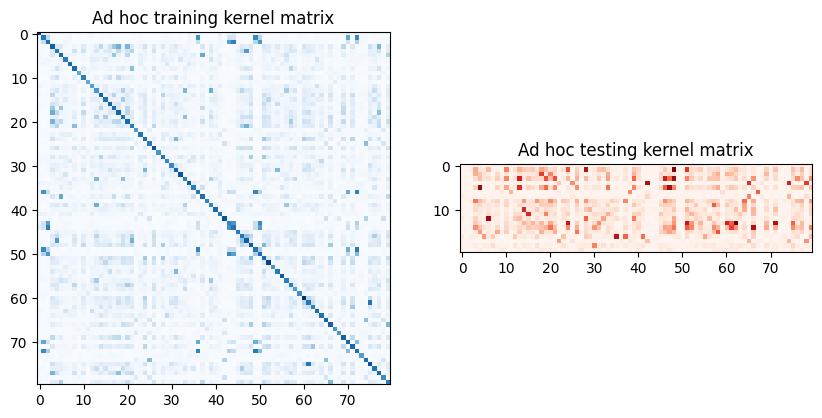

In [ ]:
from sklearn.svm import SVC 

# Precompute the quantum kernel
quant_matrix_train = quant_kernel.evaluate(x_vec = X_train_high)
quant_matrix_test = quant_kernel.evaluate(x_vec = X_test_high, y_vec = X_train_high) # a rectangular matrix, fundamental for SVM purposes

fig, axs = plt.subplots(1,2, figsize = (10, 5))

axs[0].imshow(
    np.asmatrix(quant_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(quant_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

# Create the SVM models
classic_svc  = SVC(kernel = "rbf", random_state = 42) # we use a classical kernel
quantum_svc = SVC(kernel = "precomputed", random_state = 42) # we use a quantum kernel

<small>The interesting thing is that, using SVC with a classic kernel matrix helps us in reaching a 100% accuracy, which is not achievable with the quantum kernel matrix, thanks to all the limitations already discussed on the quantum hardware.</small>

In [ ]:
# Train classical model
start_time5 = time.time()
classic_svc.fit(X_train_high, Y_train_high)
end_time5 = time.time()
class_time = end_time5 - start_time5

# Train quantum model
start_time6 = time.time()
quantum_svc.fit(quant_matrix_train, Y_train_high)
end_time6 = time.time()
quantum_time = end_time6 - start_time6

print(f"Classical SVM training time: {class_time:.4f} seconds")
print(f"Quantum SVM training time: {quantum_time:.4f} seconds")

print(classification_report(Y_test_high, classic_svc.predict(X_test_high)))
print(classification_report(Y_test_high, quantum_svc.predict(quant_matrix_test)))

Classical SVM training time: 0.0123 seconds
Quantum SVM training time: 0.0021 seconds
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82        14
         1.0       0.00      0.00      0.00         6

    accuracy                           0.70        20
   macro avg       0.35      0.50      0.41        20
weighted avg       0.49      0.70      0.58        20



c:\Users\anton\quantum\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\anton\quantum\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\anton\quantum\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Real data scenario

<small>Coming to the final part of this project, we will finally try to adopt some solutions that are proposed by scientific literature, to be finally able to use a quantum model like the ones shown before, but on a dataset composed by real network packets' data. We will at first import a real dataset from Internet, doing some initial precomputations in order to normalize all data. Following this, we will try a type of solution which has gained a lot of popularity in the research field:

1. **Principal Component Analysis (PCA)**: is a dimensionality reduction technique used in data analysis and classical machine learning. It helps us to reduce the number of features in a dataset while keeping the most important information.    

It is currently the most adopted solution in the literature, as it is basically a classical algorithm adapted to operate in a quantum context. There are also other solutions that have been proposed, such as the usage of a *Quantum Autoencoder*, that are still on an initial experimental phase, and are also more complex to implement.<br>
The dataset we will consider is the **UNSW-NB15** one, created by the Australian Centre for Cyber Security, and it consists of a collection of raw network packets, described with 49 features along with the class label. This dataset has a total number of 2,540,044 records, but for our work we will consider only a small subset, likely of 1000 samples, in order to not have a computations that can last hours, if not days.
</small>

In [6]:
# import the dataset (csv file)
import pandas as pd
df = pd.read_csv('net_datasets/UNSW_NB15_training-set.csv') 
df2 = pd.read_csv('net_datasets/UNSW_NB15_testing-set.csv')

# Reduce the train dataset to 700 samples
num_normal_train = 500
num_anomalies_train = 200
df_normal_train = df[df['label'] == 0].sample(n = num_normal_train, random_state = 42)
df_anomalies_train = df[df['label'] == 1].sample(n = num_anomalies_train, random_state = 42)
df_train = pd.concat([df_normal_train, df_anomalies_train])
df_train = df_train.sample(frac = 1, random_state = 42).reset_index(drop = True)

# Reduce the test dataset to 300 samples
num_normal_test = 200
num_anomalies_test = 100
df_normal_test = df2[df2['label'] == 0].sample(n = num_normal_test, random_state = 42)
df_anomalies_test = df2[df2['label'] == 1].sample(n = num_anomalies_test, random_state = 42)
df_test = pd.concat([df_normal_test, df_anomalies_test])
df_test = df_test.sample(frac = 1, random_state = 42).reset_index(drop = True)
    
print(f"Dimensioni del dataset di training: {df_train.shape}")
print(f"Dimensioni del dataset di test: {df_test.shape}")
df_train.head()

Dimensioni del dataset di training: (700, 45)
Dimensioni del dataset di test: (300, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,39792,0.018182,tcp,-,FIN,16,18,1540,1644,1814.981836,...,1,6,0,0,0,8,7,0,Normal,0
1,46464,0.630359,tcp,http,FIN,10,6,1582,268,23.795964,...,1,1,0,0,1,1,1,0,Backdoor,1
2,77993,0.000010,udp,-,INT,2,0,78,0,100000.002500,...,1,6,0,0,0,3,7,0,Normal,0
3,80760,0.984492,tcp,http,FIN,10,10,838,1242,19.299293,...,1,3,0,0,1,1,3,0,Normal,0
4,65868,0.725255,tcp,-,FIN,10,6,534,268,20.682380,...,1,3,0,0,0,2,3,0,Normal,0


<small>

**Attention** <br>

Before starting all the pre-optimization processes we need to train the model, we must first normalize the dataset. That is because dataset found in Internet are usually made by raw and heterogeneous data (number, strings, booleans). Several fields are *categorical*, meaning that are not defined by numerical values, so we must convert them into numbers, because only in that case these fields become useful for the prediction. In particular, we will use the so called **One-Hot Encoding**, that consist of creating a binary column for each category within a field. For example, the *Protocol* category can contain several possible strings, like TCP,UDP..., so for each of these possible values we create a binary column, named for instance *is_TCP*, that will assume value 0 or 1 if the corresponding sample is TCP or not. <br>
After that, we must apply min-max normalization to all data, ensuring that the length of the statevector $\ket{\psi}$ is equal to 1, and this is equivalent to have the measurement probability sum to 1. This is a fundamental property of quantum states.
</small>

In [7]:
from sklearn.preprocessing import MinMaxScaler

# select all the categorical fields
categorical_cols = ['proto', 'service', 'state']

# Merge the 2 datasets, in order to have the same number of columns
# We first make a copy for security
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# Add a label to later split again the 2 datasets
df_train_copy['split'] = 'train'
df_test_copy['split'] = 'test'

combined_df = pd.concat([df_train_copy, df_test_copy], ignore_index = True)

# Apply One-Hot encoding
combined_df_encoded = pd.get_dummies(combined_df, columns = categorical_cols)

# Normalize the numerical features
y = combined_df_encoded['label']
split_label = combined_df_encoded['split']
features = combined_df_encoded.drop(columns=['label', 'split','attack_cat'], errors='ignore')

# Normalizziamo solo le feature
scaler = MinMaxScaler(feature_range = (0, 1))
features_scaled = scaler.fit_transform(features)

# Creiamo un nuovo DataFrame con le feature normalizzate
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Uniamo le feature normalizzate con le etichette e la colonna 'split'
combined_df_final = pd.concat([features_scaled_df, y, split_label], axis=1)

# Dividiamo nuovamente i dati in training e test
df_train_final = combined_df_final[combined_df_final['split'] == 'train'].drop(['split'], axis=1)
df_test_final = combined_df_final[combined_df_final['split'] == 'test'].drop(['split'], axis=1)

print(df_train_final.shape)
print(df_test_final.shape)

# Check for missing values 
#print(df_train_final.isnull().values.any())
#print(df_test_final.isnull().values.any())

# Check for infinite values
print(df_train_final.isin([np.inf, -np.inf]).values.any())
print(df_test_final.isin([np.inf, -np.inf]).values.any())

df_test_final.head()


(700, 89)
(300, 89)
False
False


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,service_http,service_pop3,service_radius,service_smtp,service_ssh,state_CON,state_FIN,state_INT,state_REQ,label
700,0.292909,1.825563e-02,0.008388,0.005772,0.005489,0.000184,0.000016,1.000000,1.000000,0.000006,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
701,0.636453,7.604458e-03,0.008388,0.004329,0.004760,0.000139,0.000033,1.000000,1.000000,0.000012,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
702,0.092747,2.603832e-05,0.000932,0.001443,0.000222,0.000092,0.001924,0.122047,0.115079,0.000127,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
703,0.084049,1.685225e-05,0.000932,0.001443,0.000187,0.000084,0.002973,0.122047,0.115079,0.000174,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
704,0.382578,8.350968e-08,0.000932,0.000000,0.000342,0.000000,0.200000,1.000000,0.000000,0.054054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### PCA optimization

#### What is PCA?

<small>Principal Component Analysis, or PCA, reduces the number of  dimensions in large datasets to principal components that retain most of the original information. It does this by transforming potentially correlated variables into a smaller set of variables, called **Principal components**. <br>
PCA is commonly used for data preprocessing for use with Machine Learning algorithms. This because it reduces model complexity as the addition of each new feature negatively impacts model performance, which is commonly referred to as the "curse of dimensionality". <br>
The principal components mentioned before are linear combinations of the original variables that have the maximum variance compared to other linear combinations. These components capture as much information from the original dataset as possible. This statistical technique involves both linear algebra and matrix operations, as it transforms the original dataset into a new coordinate system that is structured by the principal components. The eigenvectors and eigenvalues from the covariance matrix that underpin the principal components allow for the analysis of these linear transformations. Two major components are calculated in PCA: the first principal component (PC1) and the second principal component (PC2).<br>

1. The *first principal component (PC1)* is the direction in space along which the data points have the highest or most variance. It is the line that best represents the shape of the projected points. The larger the variability captured in the first component, the larger the information retained from the original dataset. No other principal component can have a higher variability.
2. We calculate the *second principal component (PC2)* in the same way as PC1. PC2 accounts for the next highest variance in the dataset and must be uncorrelated with PC1. That is, PC2 must be orthogonal, that is perpendicular, to PC1. This relationship can also be expressed as the correlation between PC1 and PC2 equals zero. <br>

<img src="2-1_orthogonal-relshp_pc1-pc2-1.png" width="800"> <br>

This is a scatter plot created by using the first 2 principal components as axes. The first principal component is the x-axis, and the second principal component is the y-axis. This plot shows the relationships between observations and the new variables. The direction and length of the plot arrows indicate the loadings of the variables, that is, how each variable contributes to the principal components. If a variable has a high loading for a particular component, it is strongly correlated with that component. This can highlight which variables have a significant impact on data variations. <br> 
The number of principal components that remain after applying PCA can help you interpret the data output. The first principal component explains the most data variance, and each later component accounts for less variance. Thus, the number of components can indicate the amount of information retained from the original dataset. Fewer components after applying PCA could mean that you didn’t capture much data variation. More components indicate more data variation, but the results may be harder to interpret.</small>

In [8]:
from sklearn.decomposition import PCA
# Separate features from labels
X_train = df_train_final.drop('label', axis = 1)
y_train = df_train_final['label']

X_test = df_test_final.drop('label', axis = 1)
y_test = df_test_final['label']

# Initialize the PCA object
pca = PCA() # here we don't reduce the number of components, we just analyze what impact on the final classification has each feature
pca.fit(X_train)

pca.explained_variance_ratio_

array([4.80352090e-01, 1.13766689e-01, 8.43259807e-02, 6.35386817e-02,
       4.52790042e-02, 3.01726956e-02, 2.17259170e-02, 2.09521886e-02,
       1.63449394e-02, 1.54222944e-02, 1.26112049e-02, 1.03278626e-02,
       9.33344389e-03, 8.80581803e-03, 6.65097353e-03, 5.66678102e-03,
       5.35379292e-03, 4.20798049e-03, 3.81902311e-03, 3.37644610e-03,
       3.16150305e-03, 2.87756443e-03, 2.79078849e-03, 2.40758556e-03,
       2.14199645e-03, 1.97379777e-03, 1.52310259e-03, 1.38376887e-03,
       1.28348052e-03, 1.09322938e-03, 9.23953133e-04, 8.65119598e-04,
       8.16044191e-04, 7.75221196e-04, 7.49152955e-04, 7.07916262e-04,
       6.76275113e-04, 5.97933433e-04, 4.98917167e-04, 4.60511372e-04,
       4.60409442e-04, 4.60390879e-04, 4.60390879e-04, 4.60390879e-04,
       4.60390879e-04, 4.60390879e-04, 4.60390879e-04, 4.60390879e-04,
       4.60390879e-04, 4.60390879e-04, 4.60390879e-04, 4.59947707e-04,
       4.59804045e-04, 4.56464108e-04, 4.44888786e-04, 4.42354851e-04,
      

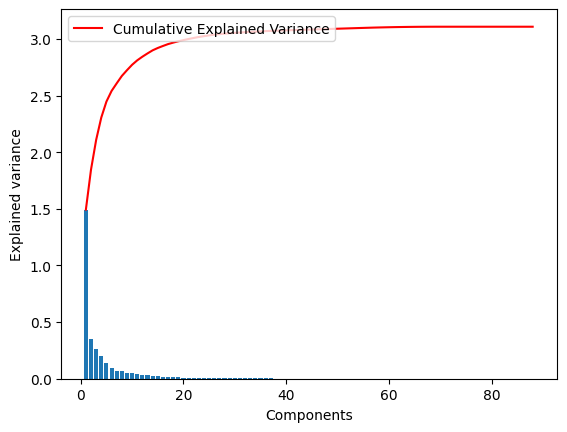

In [9]:
# We realize a plot to figure out the variance trend 
plt.bar(range(1, len(pca.explained_variance_)+1),pca.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_)+1),
         np.cumsum(pca.explained_variance_),
         c = 'red',
         label = "Cumulative Explained Variance")
plt.legend(loc = 'upper left')

<small> In the previous 2 snippets, what has been done is essentialy a deep PCA analysis on the dataset that we are using. First, the goal of this analysis was to highlight the importance of each of the 89 features, determined by calculating the maximum variance for each one of them. This shows how much information of the entire dataset is retained in a single component. We can easily see, by plotting the *pca.explained_variance_ratio_* result, an array that orders in a decreasing way the maximum variance of each component. The first ones are the ones with the higher variance, in accordance to what we saw in the explanation. <br>
An interesting plot is shown here, since we have also the cumulative variance, that helps us to understand how much information we retain by selecting a certain number of components when we want to reduce the dimension of our original dataset.<br>
At this point, we can apply the reduction to our dataset, and for instance we reduce the dimensionality to only 10 features. This means that we retain almost the 90% of the original information, as shown by *pca_final.explained_variance_ratio_.cumsum()[-1]* method, and this is quite a good result to not loose so much informations.

In [46]:
# Now we try to reduce the dimensionality
# we reduce to 10 components, here we have svd_solver = "auto" by default, but internally it will use "covariance_eigh" according to the manual
pca_final = PCA(n_components = 10)  
pca_final.fit(X_train)

X_train_pca = pca_final.transform(X_train)
X_test_pca = pca_final.transform(X_test)

print(pca_final.explained_variance_ratio_.cumsum()[-1]) # we can see below that we cover 89% of the variance

# Reattach the labels
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

pca_train_df = pd.concat([X_train_pca, y_train.reset_index(drop=True)], axis = 1)
pca_test_df = pd.concat([X_test_pca, y_test.reset_index(drop=True)], axis = 1)

pca_test_df.head()

0.8918804742584333


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,label
0,1.047449,0.490618,0.310942,0.243894,-0.164243,-0.178604,0.022711,0.012358,-0.063324,0.421280,1
1,0.857958,0.551689,0.310512,0.310626,0.000864,-0.084887,-0.062125,-0.363862,-0.321560,-0.140673,1
2,-1.535893,-1.193479,-0.410326,0.799829,-0.213822,-0.117459,-0.093238,-0.233519,-0.074192,-0.020653,0
3,-1.540874,-1.192953,-0.407125,0.789462,-0.229840,-0.098062,-0.078075,-0.218442,-0.087000,-0.021321,0
4,-1.303453,0.742489,-0.077697,-0.294413,0.498176,-0.078164,-0.233346,0.064458,0.045726,0.012949,1


<small>
Now that we have done all the pre-computation phase, we can start defining our quantum model and train it. We define at first our Feature map, which is also in this case a ZZ-feature map, that has been demostrated to be one of the more suitable solutions to map classical data that have non-linear relationships among them, into the Quantum world.<br> 
What is different from the other previous scenarios is that here we increse the number of repetitions of the circuit, in this case 3. We do this because we increase at this point the expressivity of the model, having a better mapping of classical features that can reduce the errors in the final prediction.<br>
Any additional layer introduces new trainable parameters that can be used by the model to better fit itself to data. For instance, since we are using here a VQC model, we can imagine it as a function:

$$f(x,\theta)$$

this function maps input data x to the quantum world. A circuit with more parameters $\theta$ and a more complex shape, makes the function $f$ more flexible.
</small>

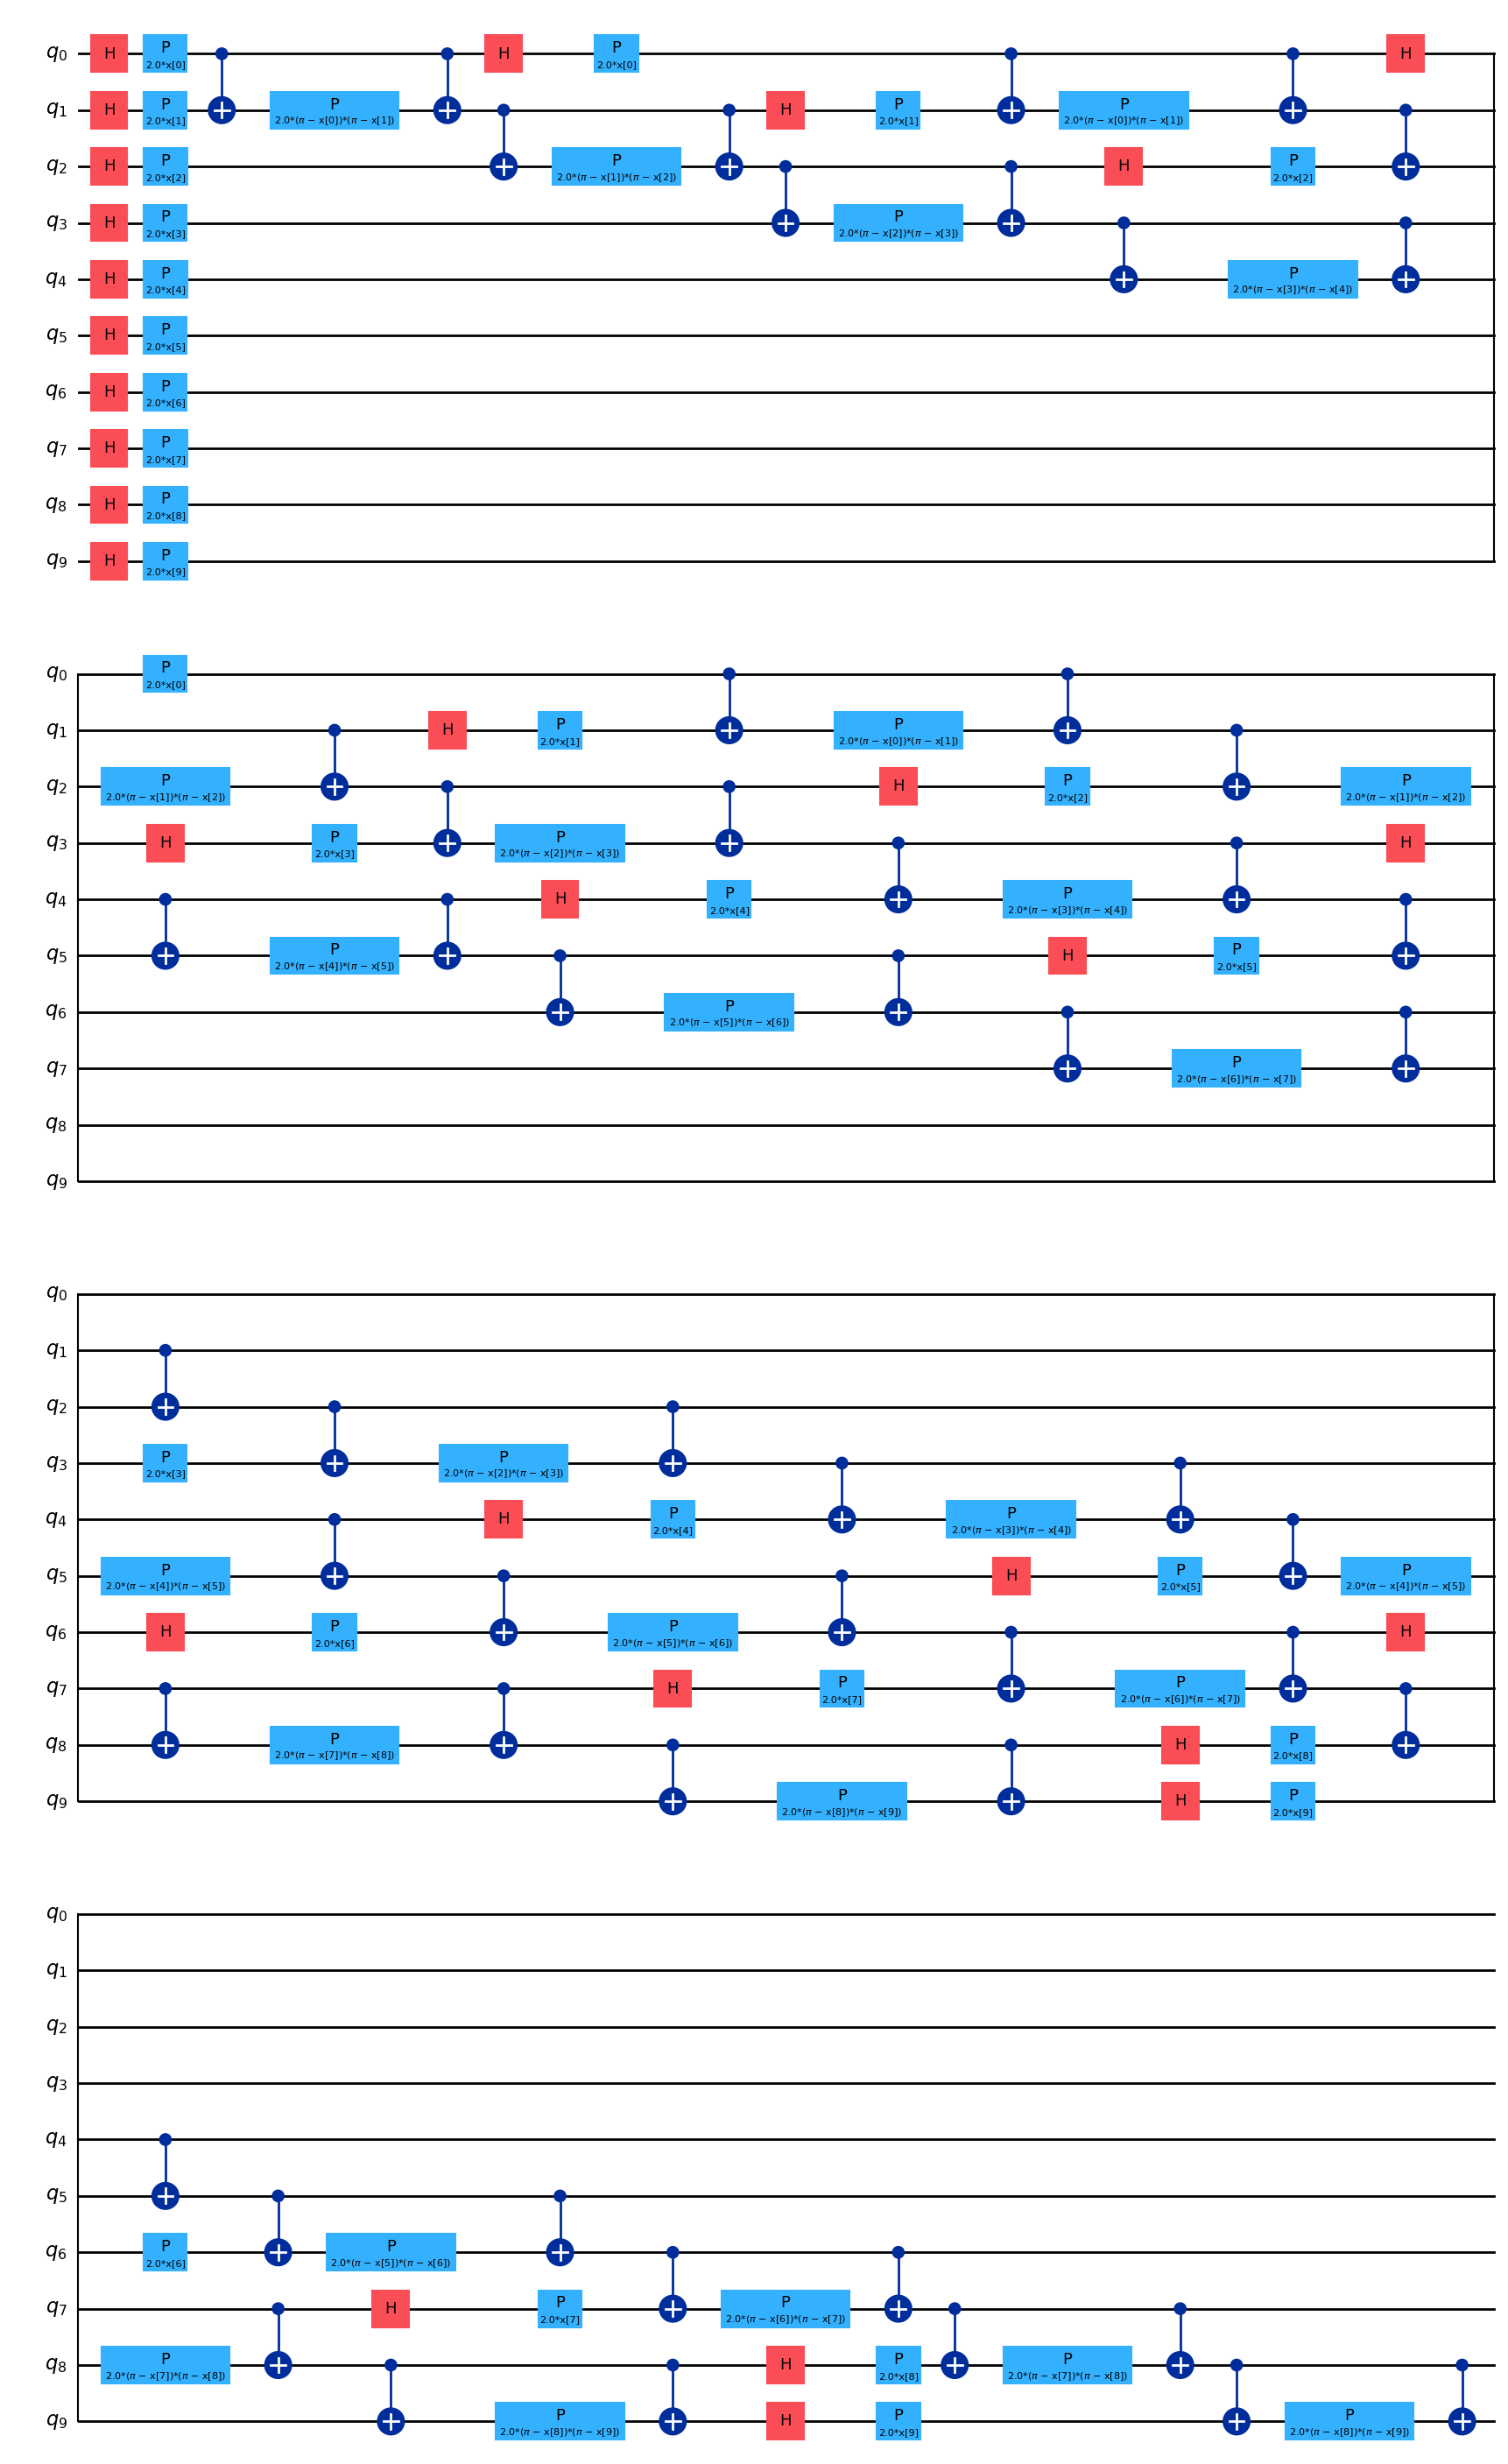

In [47]:
from qiskit.circuit.library import ZZFeatureMap
num_feature_real = 10

# Map the problem to a Quantum Circuit
zz_feature_map_real = ZZFeatureMap(
    feature_dimension = num_feature_real, entanglement = 'linear', reps = 3 # num of qubits = num of features, more repetitions for more accurate results
)
zz_feature_map_real.decompose().draw("mpl",scale = 1)

<small> Also for this last scenario, we adopt the fake Melbourne backend, with the goal to simulate the Quantum Model with the most realistic and at the same time feasible scenario. This is the best choice to respect this trade-off.

C:\Users\anton\AppData\Local\Temp\ipykernel_21972\291110477.py:3: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler_real = Sampler(backend = device_backend2)


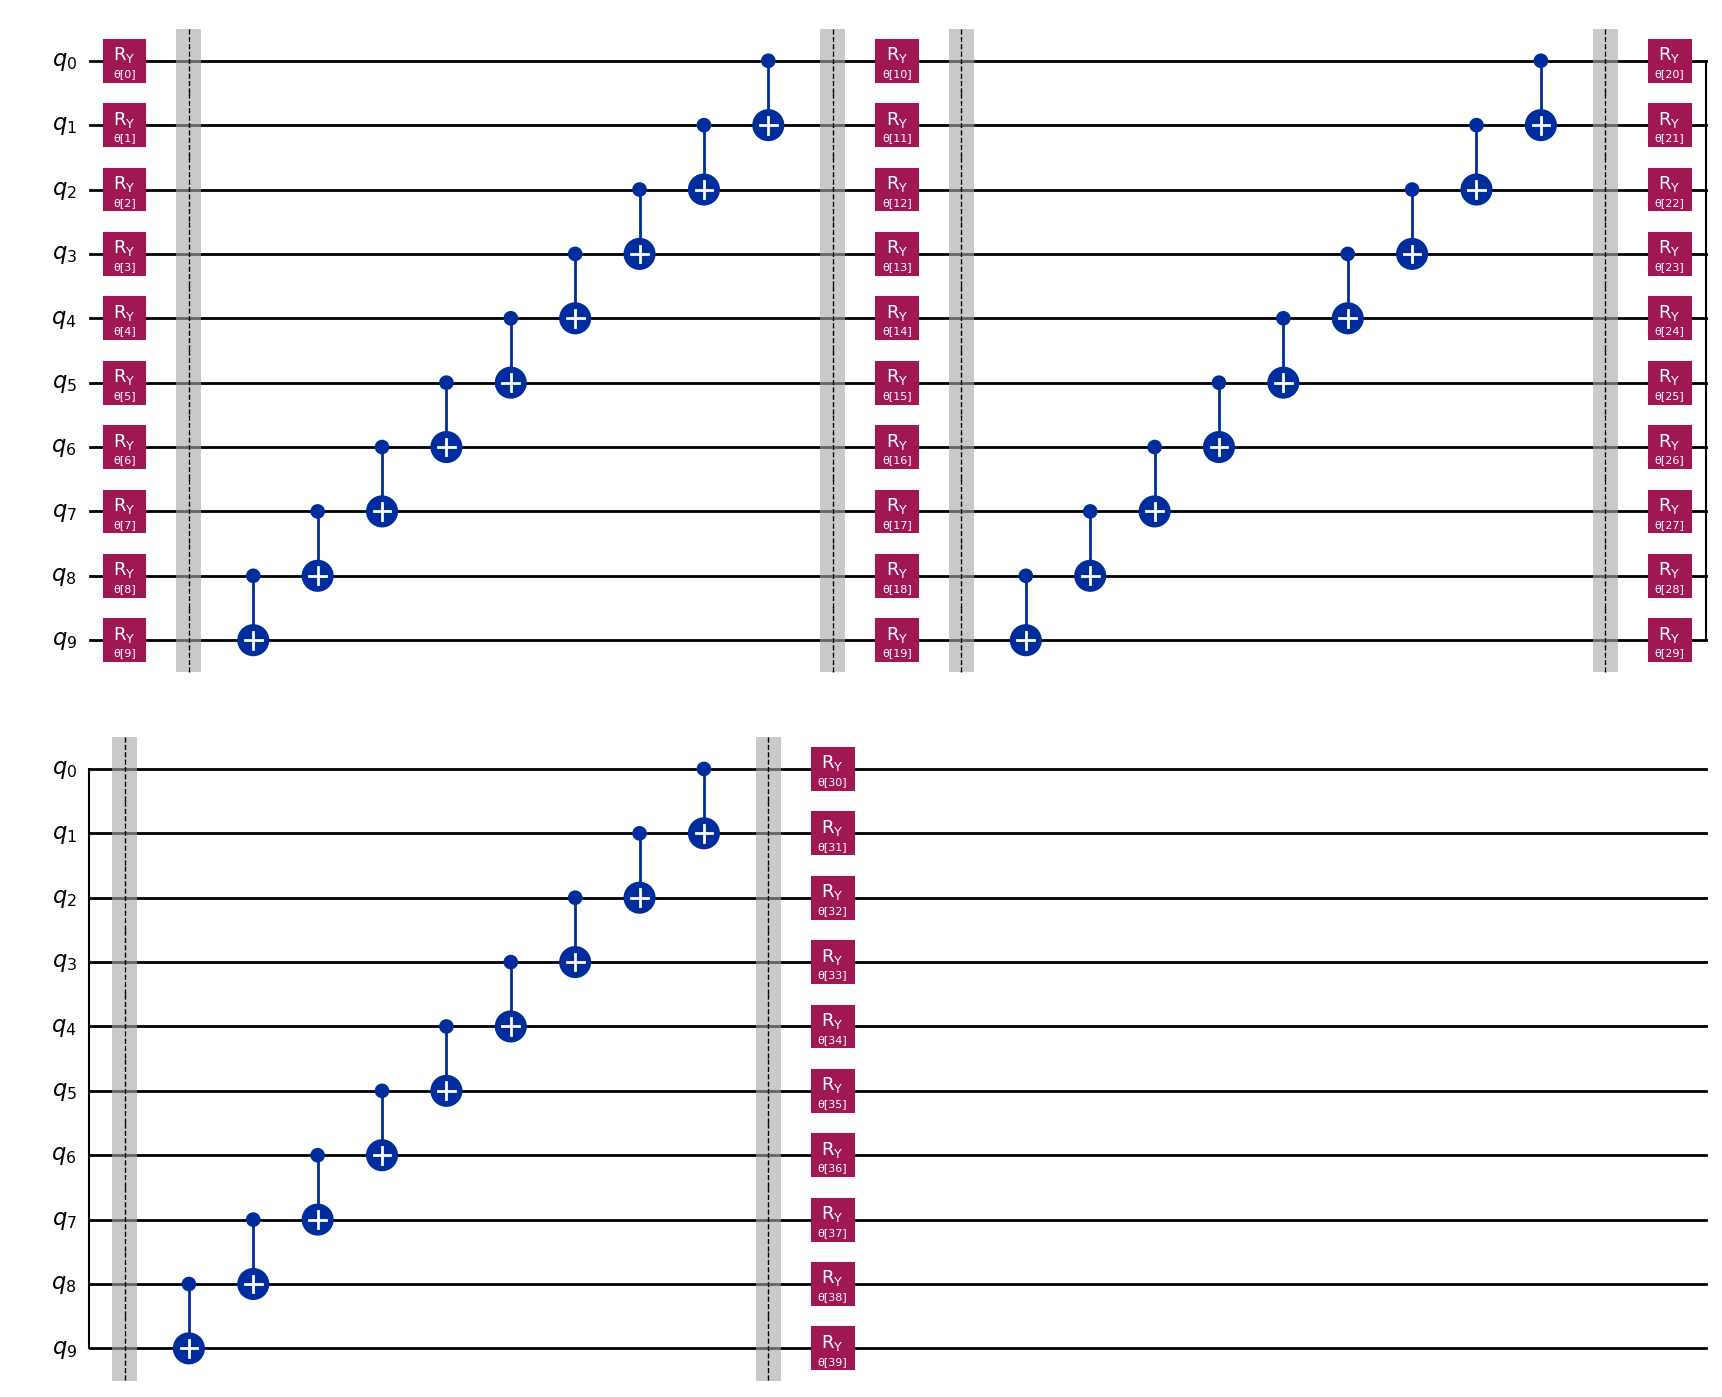

In [48]:
# we reuse the FakeMelbourne backend, to see how the quantum model behaves in a semi-realistic scenario
device_backend2 = FakeMelbourneV2()
sampler_real = Sampler(backend = device_backend2)

# construct the ansatz
ansatz_real = real_amplitudes(
    num_feature_real, reps = 3, insert_barriers = True
) # this is our Ansatz, we repeat it 2 times to have better results

ansatz_real.draw("mpl",scale = 1)

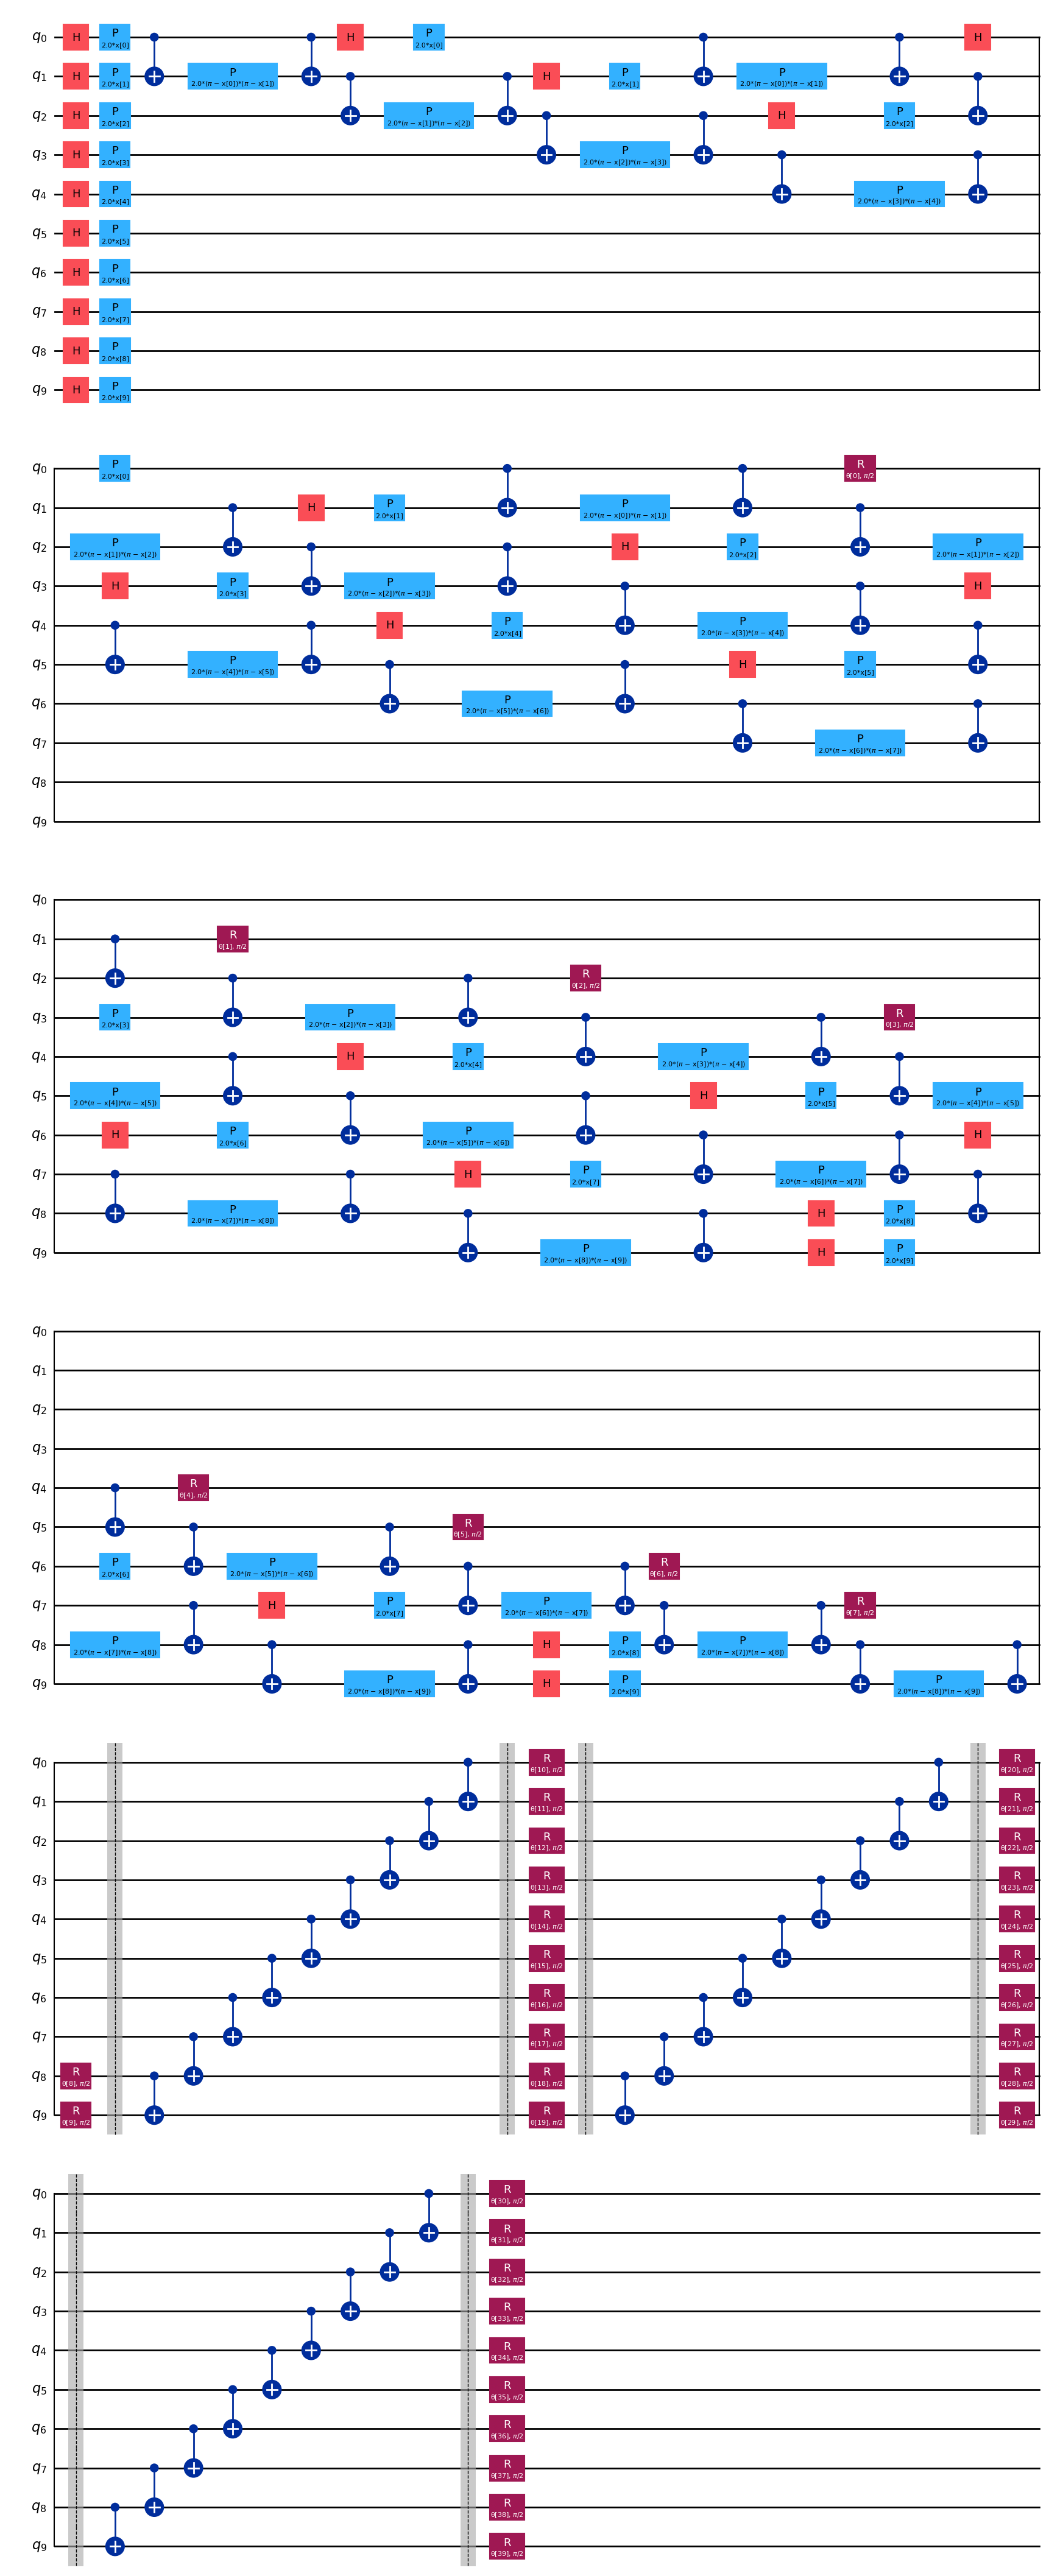

In [49]:
vqc = VQC(
    feature_map = zz_feature_map_real,
    ansatz = ansatz_real,
    loss = 'cross_entropy',
    optimizer = COBYLA(maxiter = 100), # we do not need a gradient function for COBYLA optimizer
    callback = callback_function,
    sampler = sampler_real,
)

vqc.circuit.decompose().draw("mpl",scale = 1)

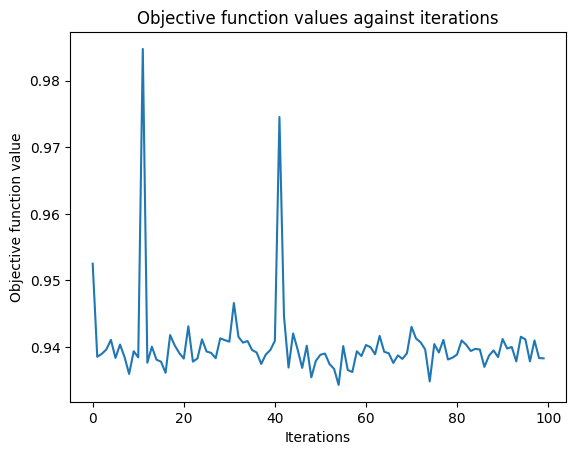

Training completed in 28384.57 seconds.


0.5666666666666667

In [50]:
Y_train = pca_train_df['label'].to_numpy()
Y_test = pca_test_df['label'].to_numpy()
#print(type(X_train))

objective_func_vals = [] # Array to store the evaluations of the objective function
start_time = time.time() # Start the timer
print("Training the model...")
vqc.fit(X_train_pca, Y_train)
end_time = time.time() # End the timer
print(f"Training completed in {end_time - start_time:.2f} seconds.")
#Test the model
vqc.score(X_test_pca, Y_test) 

<small> Looking at the results, we can easily see that the model has completed the entire train process in almost 8 hours, which is a enormous amount of time! The reason behind this behaviour can be several. Starting from the fact that when we choose to adopt an ansatz and a feature map with more repetitions, we have also the caveat to have more depth in the circuit, increasing in an exponential way the time that is needed to calculate all the parameters. We must take into consideration also that the VQC model still uses a classical optimization algorithm, in this case Cobyla, so it is not a complete quantum process. The slowness of this model is also highlighted in the upper plot, that shows the objective function value shape throughout the iterations. In this case, the optimization algorithm has not been able to find a convergence, and in fact with have a lot of oscillations, making the training process much more difficult and uncertain. <br>

## Conclusions

<small>This latest scenario helps us to understand what are the main limitations of a Quantum model when applied to a realistic dataset like the one that has been used here, and for this we can say that nowadays we are still far away to have even a small practical implementation of these models in the real life. <br>
In the literature, this method is the most common used when experiments on real datasets are done, since we still rely on a classical part to perform pre-optimizations on a dataset. However, several new approaches have been proposed in the recent years, some of them quantum and some other still classical, but that have not been implemented yet in a practical way, they are still a theoretical proposal, for the main reason that nowadays the characteristic of the most widespread Quantum computers, that rely on NISQ (*Noisy Intermediate-Scale Quantum*) cannot support the realization of these algorithms. Here we have one of the most common solutions which has been proposed: 

### *Quantum Autoencoder*
It is a circuit that can compress a quantum state into a smaller amount of qubits, while retaining the informations from the initial state. This is similar to the classical Autoencoder, which is a type of neural network architecture that is commonly used to efficiently compress and encode information from the input using of representation learning. Following compression, one can then uncompress the data through the use of a decoder. Much like the CAE, the Quantum Autoencoder aims to reduce the dimensionality of the input of the neural network, in this case a quantum state. Much like its classical counterpart, our circuit contains three layers. We first input our state $\ket{\psi}$ (which contains $n$ qubits), of which we wish to compress. This is our input layer. We then apply our parametrized circuit on our input state, which will act as our encoder and ‘compresses’ our quantum state, reducing the dimensionality of our state to $n-k$ qubits. Our new compressed state is of the form $\ket{\psi_{comp} \otimes \ket{0}^{\otimes k}}$, where $\ket{\psi_{comp}}$ contains $n-k$ qubits. <br>
This parametrized circuit will depend on a set of parameters, which will be the nodes of our Quantum Autoencoder. Throughout the training process, these parameters will be updated to optimize the loss function.<br>
We disregard the remaining $k$ qubits for the remainder of the circuit. This is our bottleneck layer and our input state is now compressed. <br>
The final layer consists of the addition of $k$ qubits (all in the state $\ket{0}$) and applying another parametrized circuit between the compressed state and the new qubits. This parametrized circuit acts as our decoder and reconstructs the input state from the compressed state using the new qubits. After the decoder, we retain the original state as the state travels to the output layer.

<img src="quantumAutoencoder.png" width="800">

**How can we use it in a Quantum model?**

In the context of QML, we can use the Quantum Autoencoder to reduce the amount of features that are inputted to our quantum model, similar to what is done by the PCA optimization. In this case we basically create an additional circuit to be executed before our quantum model circuit. The goal of this preliminar phase is to train this first circuit to memorize a compressed representation of our data.<br>
We take in consideration the *encoder* part, which takes input data with an high dimensionality (89 features), and map them with a lower number of qubit (for instance 10). The model must be first trained at this phase to minimize the cost function that indicates the reconstruction error from original data and compressed data.<br>
Once the circuit has been trained, this can be used as a "dimension reducer", not taking into consideration the *decoder* part. 

**Why it is not used?**
It is still not used nowadays because of the impractical number of qubits that the Quantum Autoencoder circuit requires on input, and this is equal to the number of features of the original dataset, which is 89. So here we encounter the same original problem that we see with the VQC circuit or with the QSVM one.

<small></small>